In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy import sparse
from scipy.sparse import linalg

## Problem 1

Use the finite element method to solve
$$ εy'' − y' = −1, $$

$$ y(0) = α, y(1) = β,$$

where α = 2, β = 4, and ε = 0.02. Use N = 100 finite elements (101 grid points). Compare
your solution with the analytic solution
$$
y(x) = α + x + (β − α − 1) \frac{e^{x/ε} − 1}{e^{1/ε} − 1}
$$

In [43]:
def a(i,j,eps,h):
    #if j is behind, make it the value given
    if j == i+1:
        return eps/h[i+1] + 1/2
    #for if j is ahead of i
    elif j == i-1:
        return eps/h[i] - 1/2
    #for the diagonal
    elif j == i:
        return -eps/h[i] - eps/h[i+1]
    else:
        return 0

def element(alpha,beta,eps,N):
    #make the array of x values
    x= np.linspace(0,1,N+1,endpoint=True)
    #initialize K the matrix, F the vector so we can solve Kb = F
    K = np.zeros((N+1,N+1))
    F = np.zeros(N+1)
    h = x - np.roll(x,1)
    #calculate the values of K using the a function
    for j in range(1,N):
        for i in range(N+1):
            K[j][i] = a(i,j,eps,h)
        F[j] = -.5*(h[j]+h[j+1])
    #change the boundary values on f and k
    F[0] = alpha
    F[-1] = beta
    K[0,0] = 1
    K[N,N] = 1
    #return the solved matrix
    return la.solve(K,F)

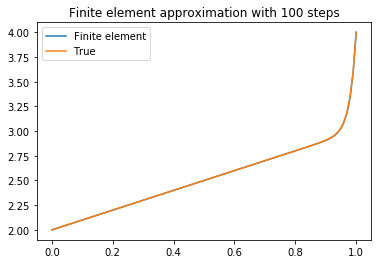

In [44]:
#plot the real
result = element(2,4,.02,100)
x = np.linspace(0,1,101)
plt.plot(x,result,label="Finite element")
y = lambda x: 2+x + (4-2-1)*((np.exp(x/.02)-1)/(np.exp(1/.02)-1))
plt.plot(x,y(x),label="True")
plt.title("Finite element approximation with 100 steps")
plt.gca().legend()
plt.show()

## Problem 2

One of the strengths of the finite element method is the ability to generate grids
that better suit the problem. The solution of (10.5) changes most rapidly near x = 1. Compare
the numerical solution when the grid points are unevenly spaced versus when the grid points
are clustered in the area of greatest change; see Figure 10.4. Specifically, use the grid points
defined by

    even_grid = np.linspace(0,1,15)
    clustered_grid = np.linspace(0,1,15)**(1./8)

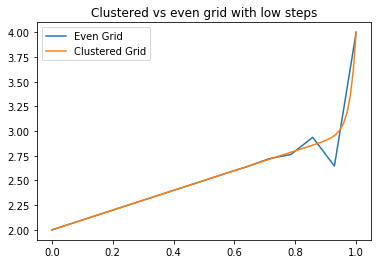

In [45]:
def element(alpha,beta,eps,N):
    #changed element method to now accept N as an array
    K = np.zeros((len(N),len(N)))
    F = np.zeros(len(N))
    h = N - np.roll(N,1)
    #get the values for K using the a function again
    for j in range(1,len(N)-1):
        for i in range(len(N)):
            K[j][i] = a(i,j,eps,h)
        F[j] = -.5*(h[j]+h[j+1])
    F[0] = alpha
    F[-1] = beta
    K[0,0] = 1
    K[len(N)-1,len(N)-1] = 1
    return la.solve(K,F)

even_grid = np.linspace(0,1,15)
clustered_grid = np.linspace(0,1,15)**(1./8)


#plot the even vs clustered element methods
even = element(2.,4.,.02,even_grid)
clust = element(2.,4.,.02,clustered_grid)
plt.plot(even_grid,even,label="Even Grid")
plt.plot(clustered_grid,clust,label="Clustered Grid")
plt.title("Clustered vs even grid with low steps")
plt.gca().legend()
plt.show()

## Problem 3

Higher order methods promise faster convergence, but typically require more work
to code. So why do we use them when a low order method will converge just as well, albeit
with more grid points? The answer concerns the roundoff error associated with floating point arithmetic. Low order methods generally require more floating point operations, so roundoff
error has a much greater effect.

The finite element method introduced here is a second order method, even though the
approximate solution is piecewise linear. (To see this, note that if the grid points are evenly
spaced, the matrix A in (10.4) is exactly the same as the matrix for the second order centered
finite difference method.)

Solve (10.5) with the finite element method using N = 2i finite elements, i = 4, 5, . . . , 21.
Use a log-log plot to graph the error; see Figure 10.5.

In [46]:

def element(alpha,beta,eps,N):
    """does finite element
    input: alpha: a float, beta: float, eps, float, N: an even grid
    returns solution to the finite element problem"""
    x= np.linspace(0,1,N+1,endpoint=True)
    F = np.zeros(N+1)
    h = x[1]-x[0]
    #make the arrays to use to construct the diagonals of the sparse matrix in the dicest way possible
    upper = np.array([eps/h-.5]*(N))
    lower = np.array([eps/h+.5]*(N))
    middle = np.array([-2*eps/h]*(N+1))
    upper[0]=0
    lower[-1] = 0
    middle[0],middle[-1] =1,1
    #create K the sparse matrix
    K = sparse.diags(middle,0) + sparse.diags(upper,1)+sparse.diags(lower,-1)
    F[:] = -h
    F[0] = alpha
    F[-1] = beta
    #solve the sparse series
    return linalg.spsolve(K,F)

#solve the finite element problem with 2^i steps with increasing i
error = []
i = [x for x in range(4,22)]
for g in i:
    error.append(la.norm(y(np.linspace(0,1,2**g+1))-element(2,4,.02,2**g)))
#     print("done with i=",g)


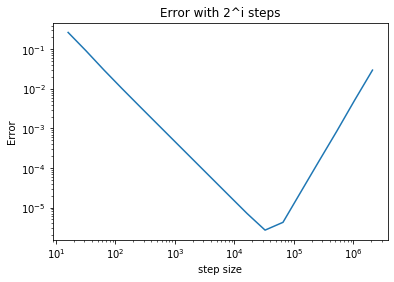

In [47]:
plt.loglog(2**np.array(i),error)
plt.title("Error with 2^i steps")
plt.xlabel("step size")
plt.ylabel("Error")
plt.show()